# Modelo MLP para Previsão de Preços de Criptomoedas (Refatorado)

## Importação das Bibliotecas

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, Normalizer, FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, PReLU, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, Adamax, AdamW, Lion, RMSprop
import joblib

## Funções do Pipeline

In [173]:
def carregar_dados(caminho_arquivo, ultimas_linhas=100000):
    """
    PASSO 1: Carrega e prepara os dados.
    Objetivo: Ler o arquivo CSV e garantir que ele esteja em ordem.
    """
    # Carrega os dados do arquivo CSV
    df = pd.read_csv(caminho_arquivo)

    # Evita o PC de explodir com muitos dados
    df = df.iloc[-ultimas_linhas:]

    # Garante que a coluna 'timestamp' seja do tipo data e ordena os dados
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df = df.reset_index(drop=True)

    # Remove colunas com nomes "Unnamed".
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    print(f"Dados carregados: {df.shape[0]} registros.")
    print(df.head())
    return df

In [174]:
def preparar_features(df, df_btc=None, df_eth=None):
    """
    PASSO 2: Preparar os Dados para o Modelo.
    Objetivo: Transformar os dados brutos em um formato que a rede neural entenda (features e target).
    """
    # --- Calculo dos Indicadores ---
    df = df.copy()

    if df_btc is not None:
        btc_features = pd.DataFrame(index=df_btc.index)
        btc_features['btc_close_pct'] = np.log1p(df_btc['close'].pct_change())
        btc_features['btc_volume_pct'] = np.log1p(df_btc['volume'].pct_change())
        btc_features['btc_price_trend'] = df_btc['close'].pct_change().rolling(10).mean()
        
        df = df.join(btc_features)
        df['btc_correlation'] = df['close'].rolling(10).corr(df_btc['close'])

    if df_eth is not None:
        eth_features = pd.DataFrame(index=df_eth.index)
        eth_features['eth_close_pct'] = np.log1p(df_eth['close'].pct_change())
        eth_features['eth_volume_pct'] = np.log1p(df_eth['volume'].pct_change())
        eth_features['eth_price_trend'] = df_eth['close'].pct_change().rolling(10).mean()

        df = df.join(eth_features)
        df['eth_correlation'] = df['close'].rolling(10).corr(df_eth['close'])

    # --- 1. Variações e transformações básicas ---
    df['close_pct'] = np.log1p(df['close'].pct_change())
    df['volume_pct'] = np.log1p(df['volume'].pct_change())

    # --- 2. Médias móveis e suas diferenças ---
    df['sma_10'] = df['close'].rolling(10).mean()
    df['sma_30'] = df['close'].rolling(30).mean()
    df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()
    df['ema_30'] = df['close'].ewm(span=30, adjust=False).mean()
    df['sma_10_vs_sma_30'] = df['sma_10'] - df['sma_30']
    df['price_vs_sma30'] = df['close'] - df['sma_30']

    # --- 3. Indicadores técnicos comuns ---
    def calc_rsi(series, period):
        delta = series.diff()
        gain = delta.clip(lower=0).rolling(period).mean()
        loss = (-delta.clip(upper=0)).rolling(period).mean()
        rs = gain / (loss + 1e-10)
        return 100 - 100 / (1 + rs)

    for p in [7, 14, 21]:
        df[f'rsi_{p}'] = calc_rsi(df['close'], p)

    def macd(series, short=12, long=26, signal=9):
        exp1 = series.ewm(span=short, adjust=False).mean()
        exp2 = series.ewm(span=long, adjust=False).mean()
        macd_line = exp1 - exp2
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        return macd_line, signal_line

    df['macd'], df['macd_signal'] = macd(df['close'])
    df['macd_diff'] = df['macd'] - df['macd_signal']

    def bollinger(series, window=20, std_dev=2):
        ma = series.rolling(window).mean()
        std = series.rolling(window).std()
        upper = ma + std_dev * std
        lower = ma - std_dev * std
        return upper, lower

    df['bb_upper'], df['bb_lower'] = bollinger(df['close'])
    df['bb_upper_diff'] = df['bb_upper'] - df['close']
    df['bb_lower_diff'] = df['close'] - df['bb_lower']

    def atr(df, window=14):
        tr = pd.concat([
            df['high'] - df['low'],
            abs(df['high'] - df['close'].shift()),
            abs(df['low'] - df['close'].shift())
        ], axis=1).max(axis=1)
        return tr.rolling(window).mean()

    df['atr_14'] = atr(df)

    # --- 4. Osciladores ---
    def stochastic(df, k_window=14, d_window=3):
        low_min = df['low'].rolling(k_window).min()
        high_max = df['high'].rolling(k_window).max()
        k = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-10)
        d = k.rolling(d_window).mean()
        return k, d

    df['so_k'], df['so_d'] = stochastic(df)

    def williams_r(df, window=14):
        low_min = df['low'].rolling(window).min()
        high_max = df['high'].rolling(window).max()
        return -100 * (high_max - df['close']) / (high_max - low_min + 1e-10)

    df['wpr_14'] = williams_r(df)

    # --- 5. Indicadores de volume ---
    # OTIMIZAÇÃO: Lógica do OBV vetorizada para muito mais performance
    price_direction = np.sign(df['close'].diff()).fillna(0)
    df['obv'] = (price_direction * df['volume']).cumsum()

    df['volume_trend'] = df['volume'].pct_change().rolling(10).mean()
    df['price_trend'] = df['close'].pct_change().rolling(10).mean()

    # --- 6. Volatilidade e desvio padrão ---
    for w in [10, 20, 40]:
        df[f'std_{w}'] = df['close'].rolling(w).std()
        df[f'volatility_{w}'] = df['close'].pct_change().rolling(w).std()

    # --- 7. Lags de indicadores principais ---
    cols_to_lag = [
        'close_pct', 'rsi_7', 'rsi_14', 'rsi_21', 'macd', 'macd_signal',
        'btc_close_pct', 'btc_volume_pct', 'btc_price_trend', 'btc_correlation',
        'eth_close_pct', 'eth_volume_pct', 'eth_price_trend', 'eth_correlation'
    ]

    for col in cols_to_lag:
        if col in df.columns:  # Apenas cria o lag se a coluna existir no df final
            df[f'lag_{col}_1'] = df[col].shift(1)
            df[f'lag_{col}_2'] = df[col].shift(2)

    # --- 8. Finalização ---
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [175]:
def definir_features_e_alvo(df):
    """Define as colunas de features e a coluna alvo, e retorna os dados brutos X e y."""
    FEATURE_COLUMNS = [
    # --- Features de Mercado Externo ---
    # Essencial para capturar a tendência geral do mercado cripto.
    'btc_close_pct',
    'eth_close_pct',
    'btc_price_trend',
    'eth_price_trend',

    # --- Features Principais do Ativo (DataFrame Principal) ---
    # As variações de preço e volume são a base da predição.
    'close_pct',
    'volume_pct',
    'price_trend',


    # --- Indicadores de Tendência e Força ---
    # Medem a direção e a força do movimento de preços.
    'sma_10_vs_sma_30', # Cruzamento de médias, indica mudança de tendência
    'price_vs_sma30',   # Distância do preço à média, indica sobre-extensão
    'macd_diff',        # Histograma MACD, um dos sinais de momentum mais fortes

    # --- Indicadores de Momento (Osciladores) ---
    # Identificam condições de sobrecompra e sobrevenda.
    'rsi_14',           # Índice de Força Relativa (período padrão)
    'so_d',             # Linha de sinal do Estocástico, mais suave que %K

    # --- Indicadores de Volatilidade ---
    # Medem a magnitude das variações de preço.
    'atr_14',           # Average True Range, mede a volatilidade real
    'bb_upper_diff',    # Distância do preço à banda superior de Bollinger
    'bb_lower_diff',    # Distância do preço à banda inferior de Bollinger

    # --- Indicador de Volume ---
    # Confirma a força da tendência com base no fluxo de volume.
    # 'obv',              # On-Balance Volume (comentado por ser dados grandes demais em comparação aos outros)

    # --- Features Defasadas (Lags) ---
    # Fornecem ao modelo uma "memória" de curto prazo sobre os indicadores-chave.
    'lag_close_pct_1',
    'lag_rsi_14_1',
    'lag_macd_1',
]

    TARGET_COLUMN = 'close'

    # O alvo (y) será binário: 1 se o preço subir, 0 se não
    # df[TARGET_COLUMN].shift(-1) pega o preço de fechamento do *próximo* período
    y = (df[TARGET_COLUMN].shift(-1) > df[TARGET_COLUMN]).astype(int)

    # As features (X) serão os dados da FEATURE_COLUMNS
    X_raw = df[FEATURE_COLUMNS]

    num_features = len(FEATURE_COLUMNS)

    print(f"Quantidade de features definidas: {num_features}")
    print(f"Shape dos dados brutos: {X_raw.shape}")
    print(f"Valores mínimos {X_raw.min()}")
    print(f"Valores máximos {X_raw.max()}")
    
    return X_raw, y, FEATURE_COLUMNS

In [176]:
def normalizar_dados(X_raw):
    """Normaliza os dados de features."""
    # --- Normalização dos Dados ---

    # Pipeline de normalização: Log transformation + Tanh transformation + Vector normalization
    
    # Função personalizada para transformação logaritma
    def log_transform(X):
        """Aplica transformação logaritma aos dados"""
        return np.log(X + 1)  # Adiciona 1 para evitar log(0)

    # Função personalizada para transformação Tanh
    def tanh_transform(X):
        """Aplica transformação tanh aos dados para reduzir outliers"""
        return np.tanh(X)

    # # Criar o pipeline de normalização
    # scaler = Pipeline([
    #     # ('log', FunctionTransformer(log_transform, validate=True)),
    #     ('tanh', FunctionTransformer(tanh_transform, validate=True)),
    #     ('normalize', Normalizer(norm='l2')),  # Normalização L2 (vetorial)
    #     # ('minmax', MinMaxScaler(feature_range=(-1, 1)))
    # ])

    scaler = RobustScaler()

    X_scaled = scaler.fit_transform(X_raw)

    print(f"Dados normalizados. Shape: {X_scaled.shape}")
    print(f"Min: {X_scaled.min():.6f}, Max: {X_scaled.max():.6f}")
    # print(f"Norma L2 das primeiras 5 amostras: {np.linalg.norm(X_scaled[:5], axis=1)}")
    return X_scaled, scaler

In [177]:
def criar_sequencias(X_scaled, y, sequence_length):
    """Cria sequências de dados para o modelo."""
    X_sequences, y_sequences = [], []

    # Verificar o tamanho correto para evitar index out of bounds
    max_index = min(len(X_scaled), len(y)) - sequence_length

    print(f"Tamanho de X_scaled: {len(X_scaled)}")
    print(f"Tamanho de y: {len(y)}")
    print(f"Sequence length: {sequence_length}")
    print(f"Max index para loop: {max_index}")

    for i in range(max_index):
        X_sequences.append(X_scaled[i : i + sequence_length])
        y_sequences.append(y[i + sequence_length - 1]) # O alvo corresponde ao final da sequência

    X = np.array(X_sequences)
    y = np.array(y_sequences)

    print(f"Sequências criadas. X shape: {X.shape}, y shape: {y.shape}")
    return X, y

In [178]:
def dividir_dados(X, y):
    """Divide os dados em conjuntos de treino e teste usando TimeSeriesSplit."""
    # --- Divisão em Treino e Teste ---
    # Divisão dos dados em treino e teste
    tscv = TimeSeriesSplit(n_splits=10)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # Tentativa de balancear as classes, evitando a mesma reposta sempre
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )

    class_weight_dict = dict(enumerate(class_weights))

    print(f"Amostras de treino: {len(X_train)}")
    print(f"Amostras de teste: {len(X_test)}")
    print(f"Distribuição do target no treino: {np.bincount(y_train)}")
    print(f"Distribuição do target no teste: {np.bincount(y_test)}")
    return X_train, X_test, y_train, y_test, class_weight_dict

In [179]:
def construir_e_compilar_modelo(sequence_length, num_features):
    """
    PASSO 3: Constrói e compila o modelo MLP.
    Objetivo: Definir a arquitetura da nossa rede neural e compilá-la.
    """
    model = Sequential()
    
    # Adiciona a camada de entrada com o formato correto
    model.add(Input(shape=(sequence_length, num_features)))

    # Camada de Entrada: Uso do Conv1D para capturar padrões temporais
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

    model.add(BatchNormalization())

    # Camada de Pooling: Reduz a dimensionalidade e extrai características importantes
    model.add(MaxPooling1D(pool_size=2))

    # Achata a saída do Conv1D para ser usada nas camadas densas
    model.add(GlobalAveragePooling1D())

    # 1ª Camada Oculta: Primeira camada que aprende os padrões
    model.add(Dense(units=64, kernel_regularizer=regularizers.l2(0.001)))

    model.add(BatchNormalization())

    # PReLU é uma ativação que pode aprender a inclinação
    model.add(PReLU())

    # Camada de Dropout: Ajuda a prevenir overfitting
    model.add(Dropout(rate=0.3))

    # 2ª Camada Oculta: Segunda camada para aprender padrões mais complexos
    model.add(Dense(units=32, kernel_regularizer=regularizers.l2(0.001)))

    model.add(BatchNormalization())

    # PReLU é uma ativação que pode aprender a inclinação
    model.add(PReLU())

    # Camada de Dropout: Ajuda a prevenir overfitting
    model.add(Dropout(rate=0.3))

    # Camada de Saída: Gera a previsão final
    model.add(Dense(units=1, activation='sigmoid'))
    
    # --- Compilação do Modelo ---
    # O modelo é compilado com o otimizador Adam e a função de perda binary_crossentropy, adequada para problemas de classificação binária
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Mostra um resumo da arquitetura do modelo
    model.summary()
    return model

In [180]:
def treinar_modelo(model, X_train, y_train, X_test, y_test, class_weight_dict):
    """
    PASSO 4: Treina o modelo.
    Objetivo: Alimentar o modelo com os dados de treino para que ele aprenda.
    """
    # Callbacks para otimizar o treinamento
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)
    ]

    history = model.fit(
        X_train,
        y_train,
        epochs=200,  # epochs: Quantas vezes o modelo verá todo o conjunto de dados de treino.
        batch_size=16,  # batch_size: Quantas amostras o modelo vê antes de atualizar seus pesos.
        validation_data=(X_test, y_test),  # Dados para validar o modelo a cada época.
        class_weight=class_weight_dict,  # Pesos das classes para lidar com desbalanceamento
        callbacks=callbacks,  # Callbacks para otimização do treinamento
        verbose=1 # Mostra uma barra de progresso.
    )
    return history

In [ ]:
def avaliar_modelo(model, X_test, y_test, df_features_teste):
    """
    PASSO 5: Avalia o modelo.
    Objetivo: Verificar o quão bem o modelo se saiu nos dados de teste,
              com a opção de aplicar um filtro condicional.
    """

    print("\n--- DISTRIBUIÇÃO DE CLASSES NO CONJUNTO DE TESTE ---")
    unique, counts = np.unique(y_test, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"Classe {label} ({'Sobe' if label == 1 else 'Não Sobe'}): {count} amostras ({count / len(y_test) * 100:.2f}%)")

    # Previsões globais (sem filtro)
    print("\n--- AVALIAÇÃO GLOBAL ---")
    probas_global = model.predict(X_test)
    preds_global = (probas_global > 0.5).astype(int)

    acc_global = accuracy_score(y_test, preds_global)
    prec_global = precision_score(y_test, preds_global, zero_division=0)
    recall_global = recall_score(y_test, preds_global, zero_division=0)
    f1_global = f1_score(y_test, preds_global, zero_division=0)
    auc_global = roc_auc_score(y_test, probas_global)

    print(f"Acurácia: {acc_global * 100:.2f}%")
    print(f"Precisão: {prec_global * 100:.2f}%")
    print(f"Recall: {recall_global * 100:.2f}%")
    print(f"F1-score: {f1_global * 100:.2f}%")
    print(f"AUC/ROC: {auc_global:.4f}")

    print("\nRelatório de Classificação (Global):")
    print(classification_report(y_test, preds_global, target_names=['Não Sobe', 'Sobe'], zero_division=0))

    # Matriz de confusão (global)
    cm_global = confusion_matrix(y_test, preds_global)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Purples', xticklabels=['Não Sobe', 'Sobe'], yticklabels=['Não Sobe', 'Sobe'])
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão (Global)')
    plt.show()

    condicao = (df_features_teste['rsi_7'] > 90) | (df_features_teste['rsi_7'] < 10)
    filtro = condicao.iloc[-len(y_test):].values

    print(f"A condição será aplicada a {sum(filtro)} de {len(y_test)} amostras de teste ({sum(filtro)/len(y_test)*100:.2f}%).")

    if sum(filtro) == 0:
        print("Nenhuma amostra de teste atendeu à condição especificada.")
        return

    X_test_filtrado = X_test[filtro]
    y_test_filtrado = y_test[filtro]

    probas_filtrado = model.predict(X_test_filtrado)
    preds_filtrado = (probas_filtrado > 0.5).astype(int)

    acc = accuracy_score(y_test_filtrado, preds_filtrado)
    prec = precision_score(y_test_filtrado, preds_filtrado, zero_division=0)
    recall = recall_score(y_test_filtrado, preds_filtrado, zero_division=0)
    f1 = f1_score(y_test_filtrado, preds_filtrado, zero_division=0)
    auc = roc_auc_score(y_test_filtrado, probas_filtrado)

    print(f"Acurácia: {acc * 100:.2f}%")
    print(f"Precisão: {prec * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-score: {f1 * 100:.2f}%")
    print(f"AUC/ROC: {auc:.4f}")

    print("\nRelatório de Classificação (Filtrado):")
    print(classification_report(y_test_filtrado, preds_filtrado, target_names=['Não Sobe', 'Sobe'], zero_division=0))

    # Matriz de confusão (filtrada)
    cm = confusion_matrix(y_test_filtrado, preds_filtrado)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sobe', 'Sobe'], yticklabels=['Não Sobe', 'Sobe'])
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão (Condicional)')
    plt.show()

In [182]:
def visualizar_treinamento(history):
    """
    PASSO 6: Visualiza o treinamento.
    Objetivo: Plotar gráficos para ver se o modelo aprendeu bem ou se teve overfitting.
    """
    plt.figure(figsize=(12, 5))

    # Gráfico da Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia ao Longo das Épocas')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Gráfico da Perda (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treino')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda ao Longo das Épocas')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [183]:
def salvar_modelo_e_scaler(model, scaler):
    """
    PASSO 7: Salva o modelo e o normalizador.
    Objetivo: Salvar o modelo treinado e o normalizador para uso futuro.
    """
    # Por enquanto não é necessário salvar o modelo

    MODEL_PATH = "mlp_basic_model.h5"
    SCALER_PATH = "basic_scaler.pkl"

    model.save(MODEL_PATH)
    joblib.dump(scaler, SCALER_PATH)

    print(f"Modelo salvo em: {MODEL_PATH}")
    print(f"Normalizador salvo em: {SCALER_PATH}")

    print("Função 'salvar_modelo_e_scaler' chamada, mas a funcionalidade está comentada conforme o original.")

## Execução Principal (Main)

Dados carregados: 17520 registros.
            timestamp   open   high    low  close     volume
0 2023-07-20 16:00:00  25.69  25.77  25.21  25.51  414795.24
1 2023-07-20 17:00:00  25.52  25.67  25.40  25.57  150201.53
2 2023-07-20 18:00:00  25.58  25.58  25.25  25.40  193565.98
3 2023-07-20 19:00:00  25.40  25.52  25.27  25.39  141808.90
4 2023-07-20 20:00:00  25.40  25.40  25.03  25.23  238536.03
Dados carregados: 17520 registros.
            timestamp      open      high       low     close      volume
0 2023-07-20 16:00:00  29810.17  29872.71  29658.02  29716.69  1970.22685
1 2023-07-20 17:00:00  29716.69  29820.00  29694.38  29756.73  1137.21598
2 2023-07-20 18:00:00  29756.72  29795.52  29570.96  29687.84  2644.23439
3 2023-07-20 19:00:00  29687.84  29762.31  29675.01  29756.00   987.17978
4 2023-07-20 20:00:00  29756.00  29769.75  29669.56  29739.72   791.24080
Dados carregados: 17520 registros.
            timestamp     open     high      low    close      volume
0 2023-07-20 16

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 32, 128)        │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_22 (PReLU)              │ (None, 64)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_23 (PReLU)              │ (None, 32)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,009 (89.88 KB)

 Trainable params: 22,561 (88.13 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/200
992/992 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4952 - loss: 0.8628 - val_accuracy: 0.5022 - val_loss: 0.7727 - learning_rate: 0.0010
Epoch 2/200
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5074 - loss: 0.7701 - val_accuracy: 0.4984 - val_loss: 0.7318 - learning_rate: 0.0010
Epoch 3/200
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5061 - loss: 0.7283 - val_accuracy: 0.4978 - val_loss: 0.7107 - learning_rate: 0.0010
Epoch 4/200
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5049 - loss: 0.7093 - val_accuracy: 0.4984 - val_loss: 0.7018 - learning_rate: 0.0010
Epoch 5/200
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5015 - loss: 0.7015 - val_accuracy: 0.5079 - val_loss: 0.6988 - learning_rate: 0.0010
Epoch 6/200
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4982 - loss: 0.6979 - val_accuracy: 0.4826 - val_loss: 0.6971 - learning_rate: 0.0010
Epoch 7/200
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4996 - loss: 0.

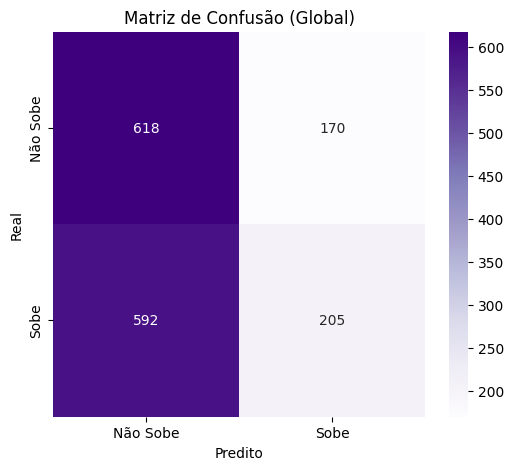

A condição será aplicada a 329 de 1585 amostras de teste (20.76%).
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acurácia: 46.81%
Precisão: 39.68%
Recall: 15.43%
F1-score: 22.22%
AUC/ROC: 0.3823

Relatório de Classificação (Filtrado):
              precision    recall  f1-score   support

    Não Sobe       0.48      0.77      0.60       167
        Sobe       0.40      0.15      0.22       162

    accuracy                           0.47       329
   macro avg       0.44      0.46      0.41       329
weighted avg       0.44      0.47      0.41       329



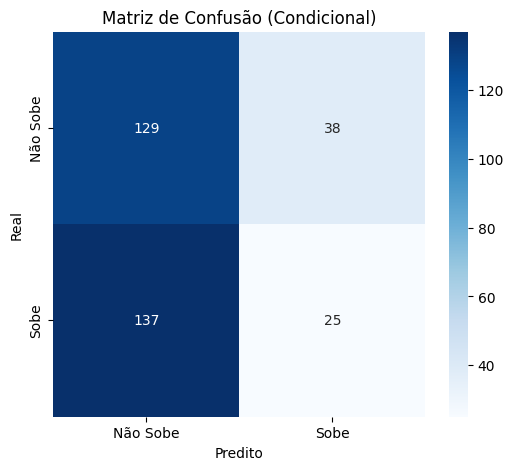

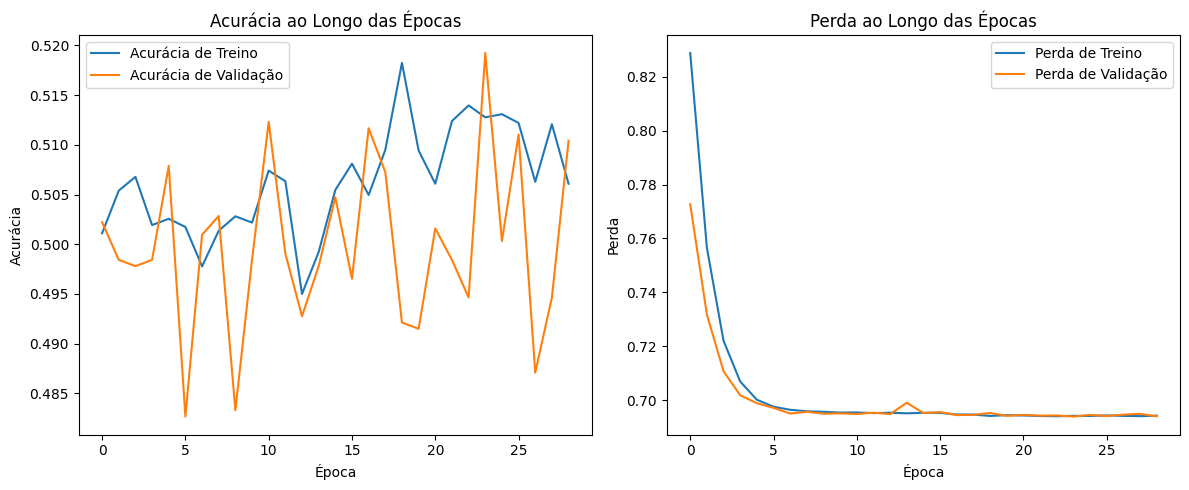

In [184]:
if __name__ == '__main__':
    # --- Definições Globais ---
    CAMINHO_ARQUIVO = r"..\..\data\fechamentos\SOLUSDT_1h_data.csv"
    SEQUENCE_LENGTH = 36 # Quantos períodos olharemos para trás para prever o próximo

    # --- PASSOS DO PROCESSO ---
    # Passo 0: Puxar dados de outras criptos para comparação de comportamento
    CAMINHO_ARQUIVO_BTC = r"..\..\data\fechamentos\BTCUSDT_1h_data.csv"
    CAMINHO_ARQUIVO_ETH = r"..\..\data\fechamentos\ETHUSDT_1h_data.csv"

    # PASSO 1: Carregar os dados
    df_original = carregar_dados(CAMINHO_ARQUIVO)
    df_comparacao_btc = carregar_dados(CAMINHO_ARQUIVO_BTC)
    df_comparacao_eth = carregar_dados(CAMINHO_ARQUIVO_ETH)

    # PASSO 2: Preparar features
    df_features = preparar_features(df_original, df_comparacao_btc, df_comparacao_eth)

    # PASSO 2.1: Definir features e alvo
    X_raw, y_raw, feature_columns = definir_features_e_alvo(df_features)
    NUM_FEATURES = len(feature_columns)

    # PASSO 2.2: Normalizar dados
    X_scaled, scaler = normalizar_dados(X_raw)
    
    # PASSO 2.3: Criar sequências
    X_seq, y_seq = criar_sequencias(X_scaled, y_raw, SEQUENCE_LENGTH)
    
    # PASSO 2.4: Dividir em treino e teste
    X_train, X_test, y_train, y_test, class_weights = dividir_dados(X_seq, y_seq)
    inicio_teste = len(df_features) - len(X_test)
    df_features_teste = df_features.iloc[inicio_teste:].reset_index(drop=True)

    # PASSO 3: Construir e compilar o modelo
    modelo = construir_e_compilar_modelo(SEQUENCE_LENGTH, NUM_FEATURES)
    
    # PASSO 4: Treinar o modelo
    historico = treinar_modelo(modelo, X_train, y_train, X_test, y_test, class_weights)
    
    # PASSO 5: Avaliar o modelo
    avaliar_modelo(modelo, X_test, y_test, df_features_teste)
    
    # PASSO 6: Visualizar o treinamento
    visualizar_treinamento(historico)
    
    # PASSO 7: Salvar o modelo
    # salvar_modelo_e_scaler(modelo, scaler)

## Conclusão

### Já integrado:

1. **Carrega dados históricos**
2. **Prepara os dados**
3. **Constrói um MLP**
4. **Treina o modelo**
5. **Avalia o desempenho**
6. **Visualiza o treinamento**
7. **Salva o modelo**

### Próximos Passos:
- ENTENDER POR QUE O MODELO SÓ FALA QUE VAI SUBIR (ERA POR CAUSA DO MINMAXSCALER, POR TER MUITOS OUTLIERS ELE APERTAVA VALORES INTERMEDIARIOS EM UM INTERVALO MUITO PEQUENO... TROQUEI PARA STANDARDSCALER)
- Adicionar features técnicas, prepara-las e dar ao treino do modelo (não creio que esteja bom ainda)
- Implementar validação cruzada temporal (implementei)
- Testar diferentes janelas temporais

# Testes com outros modelos

**Meio freestyle considerando que os dados são reciclados e não adaptados**

In [185]:
# from sklearn.ensemble import HistGradientBoostingClassifier
# from sklearn.metrics import classification_report

# print("--- Executando Testes alternativos com HistGradientBoosting ---")

# # Crie e treine o modelo
# hgd_model = HistGradientBoostingClassifier(max_iter=100, random_state=42)
# hgd_model.fit(X_train, y_train)

# # Faça previsões
# hgd_predictions = hgd_model.predict(X_test)
# # Avalie o resultado
# print("\nRelatório de Classificação do HistGradientBoosting:")
# print(classification_report(y_test, hgd_predictions, target_names=['Não Sobe', 'Sobe']))

In [186]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

# print("--- Executando Testes alternativos com RandomForest ---")

# # Crie e treine o modelo
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
# rf_model.fit(X_train, y_train)

# # Faça previsões
# rf_predictions = rf_model.predict(X_test)
# # Avalie o resultado
# print("\nRelatório de Classificação do RandomForest:")
# print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

In [187]:
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import classification_report

# print("--- Executando Testes alternativos com GradientBoosting ---")

# # Crie e treine o modelo
# rf_model = GradientBoostingClassifier(
#     n_estimators=200,         # Mais árvores pode melhorar, mas aumenta o tempo de treino
#     learning_rate=0.05,       # Menor learning_rate pode melhorar generalização, mas exige mais árvores
#     max_depth=4,              # Profundidade das árvores (3-5 é comum)
#     subsample=0.8,            # Amostragem estocástica para robustez (0.8 é um bom começo)
#     max_features='sqrt',      # Considera sqrt(n_features) em cada split (ajuda a evitar overfitting)
#     random_state=42
# )
# rf_model.fit(X_train, y_train)

# # Faça previsões
# rf_predictions = rf_model.predict(X_test)
# # Avalie o resultado
# print("\nRelatório de Classificação do GradientBoosting:")
# print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

In [188]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.metrics import classification_report
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# print("--- Executando Testes alternativos com StackingClassifier ---")

# # Crie e treine o modelo
# estimators = [
#     ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')),
#     ('gb', GradientBoostingClassifier(
#         n_estimators=100,
#         learning_rate=0.05,
#         max_depth=4,
#         subsample=0.8,
#         max_features='sqrt',
#         random_state=42
#     ))
# ]

# rf_model = StackingClassifier(
#     estimators=estimators,
#     final_estimator=RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight='balanced'),
#     n_jobs=-1,
#     passthrough=False
# )
# rf_model.fit(X_train, y_train)

# # Faça previsões
# rf_predictions = rf_model.predict(X_test)
# # Avalie o resultado
# print("\nRelatório de Classificação do StackingClassifier:")
# print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

In [189]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.metrics import classification_report

# print("--- Executando Testes alternativos com ExtraTreesClassifier ---")

# # Crie e treine o modelo
# rf_model = ExtraTreesClassifier(
#     n_estimators=200,         # Número de árvores na floresta
#     max_depth=6,              # Profundidade máxima das árvores (ajuda a evitar overfitting)
#     max_features='sqrt',      # Número de features consideradas em cada split
#     min_samples_split=5,      # Mínimo de amostras para dividir um nó interno
#     min_samples_leaf=3,       # Mínimo de amostras em cada folha
#     class_weight='balanced',  # Balanceia as classes automaticamente
#     n_jobs=-1,                # Usa todos os núcleos disponíveis
#     random_state=42           # Reprodutibilidade
# )
# rf_model.fit(X_train, y_train)

# # Faça previsões
# rf_predictions = rf_model.predict(X_test)
# # Avalie o resultado
# print("\nRelatório de Classificação do ExtraTreesClassifier:")
# print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))